
## 📘 Feature Extraction Overview

This notebook extracts a comprehensive set of features from time-series signals using:

- **Time-domain analysis**
- **Frequency-domain analysis**
- **Autocorrelation**
- **Empirical Mode Decomposition (EMD)**
- **Hilbert-Huang Transform (HHT)**

These features are useful for classification, anomaly detection, and understanding signal behavior in mechanical, biomedical, and other physical systems.

### 🕒 Time-Domain Features

| Feature | Description |
|--------|-------------|
| `mean` | Average value of the signal. Indicates baseline level. |
| `std` | Standard deviation. Measures variability or spread. |
| `min`, `max` | Minimum and maximum values. Show signal range. |
| `skew` | Asymmetry of the signal distribution. Positive skew = longer tail on right. |
| `kurtosis` | "Tailedness" of the distribution. High kurtosis = more outliers. |
| `energy` | Sum of squared values. Represents signal power. |
| `peak_to_peak` | Difference between max and min. Measures amplitude range. |
| `zero_crossings` | Number of times the signal crosses zero. Indicates frequency content or oscillatory nature. |

### 📊 Frequency-Domain Features (via Welch PSD)

| Feature | Description |
|--------|-------------|
| `dominant_freq` | Frequency with highest power. Often the main oscillation. |
| `spectral_entropy` | Complexity of the spectrum. Higher = more uniform distribution (noisy). |
| `spectral_centroid` | "Center of mass" of the spectrum. Indicates where most energy is concentrated. |
| `spectral_bandwidth` | Spread of the spectrum around the centroid. |
| `spectral_flatness` | Ratio of geometric mean to arithmetic mean of PSD. High = noise-like, low = tone-like. |

### 🔁 Autocorrelation Feature

| Feature | Description |
|--------|-------------|
| `autocorr_peak` | Peak of autocorrelation (excluding lag 0), normalized. Measures periodicity or self-similarity. |

### 🌊 EMD-HHT Features

These are derived from **Empirical Mode Decomposition (EMD)** and **Hilbert Transform**:

| Feature | Description |
|--------|-------------|
| `num_imfs` | Number of Intrinsic Mode Functions (IMFs) extracted. More IMFs = more complexity. |
| `total_imf_energy` | Sum of energy across all IMFs. Indicates how much signal is captured by decomposition. |
| `mean_inst_freq` | Average instantaneous frequency across IMFs. Captures dynamic frequency behavior. |
| `mean_inst_amp` | Average amplitude envelope across IMFs. Reflects signal strength over time. |


In [ ]:

import numpy as np
from scipy.signal import hilbert, welch, correlate
from scipy.stats import skew, kurtosis
from PyEMD import EMD

def extract_features_with_emd_hht(signal, fs=1000):
    features = {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'min': np.min(signal),
        'max': np.max(signal),
        'skew': skew(signal),
        'kurtosis': kurtosis(signal),
        'energy': np.sum(signal**2),
        'peak_to_peak': np.ptp(signal),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum()
    }

    freqs, psd = welch(signal, fs=fs)
    features['dominant_freq'] = freqs[np.argmax(psd)]
    features['spectral_entropy'] = -np.sum(psd * np.log(psd + 1e-8))
    features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd)
    features['spectral_bandwidth'] = np.sqrt(np.sum(((freqs - features['spectral_centroid'])**2) * psd) / np.sum(psd))
    features['spectral_flatness'] = np.exp(np.mean(np.log(psd + 1e-8))) / (np.mean(psd) + 1e-8)

    autocorr = correlate(signal - np.mean(signal), signal - np.mean(signal), mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    features['autocorr_peak'] = np.max(autocorr[1:]) / autocorr[0] if autocorr[0] != 0 else 0

    emd = EMD()
    imfs = emd.emd(signal)
    features['num_imfs'] = len(imfs)
    features['total_imf_energy'] = sum(np.sum(imf**2) for imf in imfs)

    inst_freqs = []
    inst_amps = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) * fs / (2.0 * np.pi)

        if len(instantaneous_frequency) > 0:
            inst_freqs.append(np.mean(instantaneous_frequency))
            inst_amps.append(np.mean(amplitude_envelope))

    features['mean_inst_freq'] = np.mean(inst_freqs) if inst_freqs else 0
    features['mean_inst_amp'] = np.mean(inst_amps) if inst_amps else 0

    return features

# Example usage
fs = 1000
T = 1
t = np.linspace(0, T, fs*T)
signal = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)
features = extract_features_with_emd_hht(signal, fs)
for k, v in features.items():
    print(f"{k}: {v}")



## 🐱 CatBoost Classifier

[CatBoost](https://www.geeksforgeeks.org/machine-learning/catboost-ml/) is a gradient boosting algorithm developed by Yandex. It is particularly effective for:

- Handling categorical features automatically
- Reducing overfitting
- Fast training and prediction

It supports classification, regression, and ranking tasks.

Below is a simple example of training a CatBoostClassifier on a synthetic dataset.


In [ ]:

from catboost import CatBoostClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load dataset
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.4f}")


In [4]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch, correlate, hilbert
from PyEMD import EMD
import matplotlib.pyplot as plt
from scipy.fft import fft
# pca 
from sklearn.decomposition import PCA


In [5]:

# Time vector
# Input parameters
fs = 500.0
T = 5.0
No_of_signals_per_class = 1000

# Time vector
t = np.arange(0.0, T, 1.0 / fs)

# Signal generation functions
def diverging_oscillation(t, f, A0, growth, phase):
    mod_freq = 0.5 * f
    env = A0 * np.exp(growth * t) * (1 + 0.3 * np.sin(2 * np.pi * mod_freq * t))
    return env * np.sin(2 * np.pi * f * t + phase + 0.2 * np.sin(2 * np.pi * mod_freq * t))


def converging_oscillation(t, f, A0, decay, phase):
    env = A0 * np.exp(-decay * t)
    chirp = f * (1 - 0.5 * t)
    return env * np.sin(2 * np.pi * chirp * t + phase)


def constant_amplitude_oscillation(t, f, A, phase):
    return A * (np.sin(2 * np.pi * f * t + phase) + 0.5 * np.sin(2 * np.pi * 1.5 * f * t + phase + 0.3 * np.sin(2 * np.pi * 0.2 * t)))


def intermittent_oscillation(t, f, A, gate_period, duty, phase):
    gate = ((t % gate_period) < (duty * gate_period)).astype(float)
    mod = 1 + 0.2 * np.sin(2 * np.pi * 0.5 * t)
    y = A * mod * np.sin(2 * np.pi * f * t + phase)
    return gate * y


def chaotic_oscillation(t, f, A, noise_std, phase, rng):
    noise = rng.normal(0.0, noise_std, size=t.shape)
    jitter = f + 0.5 * np.sin(2 * np.pi * 0.3 * t)
    return A * np.sin(2 * np.pi * jitter * t + phase + 0.1 * noise) + noise


def non_oscillatory_linear(t, slope, intercept):
    return slope * t + intercept

def non_oscillatory_constant(t, value):
    return np.full_like(t, fill_value=value, dtype=float)

def noisy_flat_signal(t, noise_std, rng):
    return rng.normal(0.0, noise_std, size=t.shape)

def non_oscillatory_mix(t, rng):
    choice = rng.choice(['linear', 'constant', 'noise', 'step', 'ramp'], p=[0.3, 0.2, 0.2, 0.15, 0.15])
    if choice == 'linear':
        slope = rng.uniform(-0.6, 0.6)
        intercept = rng.uniform(-0.5, 0.5)
        y = slope * t + intercept + rng.normal(0, 0.05, size=t.shape)
    elif choice == 'constant':
        value = rng.uniform(-1.0, 1.0)
        y = np.full_like(t, value) + rng.normal(0, 0.05, size=t.shape)
    elif choice == 'noise':
        y = rng.normal(0.0, rng.uniform(0.2, 0.8), size=t.shape)
    elif choice == 'step':
        y = np.where(t < 0.5, rng.uniform(-1, 0), rng.uniform(0, 1)) + rng.normal(0, 0.05, size=t.shape)
    else:  # ramp
        y = np.piecewise(t, [t < 0.5, t >= 0.5], [lambda t: t, lambda t: 1 - t]) + rng.normal(0, 0.05, size=t.shape)
    return y


# Feature extraction with additional features

def extract_features_with_emd_hht_fft(signal, fs=1000):
    features = {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'min': np.min(signal),
        'max': np.max(signal),
        'skew': skew(signal),
        'kurtosis': kurtosis(signal),
        'energy': np.sum(signal**2),
        'peak_to_peak': np.ptp(signal),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum()
    }

    # Frequency domain features (Welch)
    freqs, psd = welch(signal, fs=fs)
    features['dominant_freq'] = freqs[np.argmax(psd)]
    features['spectral_entropy'] = -np.sum(psd * np.log(psd + 1e-8))
    features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd)
    features['spectral_bandwidth'] = np.sqrt(np.sum(((freqs - features['spectral_centroid'])**2) * psd) / np.sum(psd))
    features['spectral_flatness'] = np.exp(np.mean(np.log(psd + 1e-8))) / (np.mean(psd) + 1e-8)

    # FFT features
    fft_vals = np.abs(fft(signal))[:len(signal)//2]
    fft_norm = fft_vals / np.sum(fft_vals)
    features['fft_max'] = np.max(fft_vals)
    features['fft_mean'] = np.mean(fft_vals)
    features['fft_std'] = np.std(fft_vals)
    features['fft_entropy'] = -np.sum(fft_norm * np.log(fft_norm + 1e-12))

    # Autocorrelation
    autocorr = correlate(signal - np.mean(signal), signal - np.mean(signal), mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    features['autocorr_peak'] = np.max(autocorr[1:]) / autocorr[0] if autocorr[0] != 0 else 0

    # EMD decomposition
    emd = EMD()
    imfs = emd.emd(signal)
    features['num_imfs'] = len(imfs)
    features['total_imf_energy'] = sum(np.sum(imf**2) for imf in imfs)

    # Hilbert transform on IMFs
    inst_freqs = []
    inst_amps = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) * fs / (2.0 * np.pi)

        if len(instantaneous_frequency) > 0:
            inst_freqs.append(np.mean(instantaneous_frequency))
            inst_amps.append(np.mean(amplitude_envelope))

    features['mean_inst_freq'] = np.mean(inst_freqs) if inst_freqs else 0
    features['mean_inst_amp'] = np.mean(inst_amps) if inst_amps else 0
    return features



# Signal generation
rng = np.random.default_rng(42)
labels = ['diverging', 'converging', 'constant_amp', 'intermittent', 'chaotic', 'non_osc']
data = []
signals = []
meta = []

for label in labels:
    for i in range(No_of_signals_per_class):
        if label == 'diverging':
            f = rng.uniform(0.5, 10)  # wider frequency range
            A0 = rng.uniform(0.05, 1.0) 
            growth = rng.uniform(0.05, 2.0) 
            phase = rng.uniform(0, 2*np.pi)
            sig = diverging_oscillation(t, f=f, A0=A0, growth=growth, phase=phase)

        elif label == 'converging':
            f = rng.uniform(0.5, 10)
            A0 = rng.uniform(0.5, 2.0)
            decay = rng.uniform(0.05, 2.0)
            phase = rng.uniform(0, 2*np.pi)
            sig = converging_oscillation(t, f=f, A0=A0, decay=decay, phase=phase)

        elif label == 'constant_amp':
            f = rng.uniform(0.5, 10)
            A = rng.uniform(0.2, 2.0)
            phase = rng.uniform(0, 2*np.pi)
            sig = constant_amplitude_oscillation(t, f=f, A=A, phase=phase)

        elif label == 'intermittent':
            f = rng.uniform(0.5, 10)
            A = rng.uniform(0.2, 2.0)
            gate_period = rng.uniform(0.2, 3.0)
            duty = rng.uniform(0.1, 0.9)
            phase = rng.uniform(0, 2*np.pi)
            sig = intermittent_oscillation(t, f=f, A=A, gate_period=gate_period, duty=duty, phase=phase)

        elif label == 'chaotic':
            f = rng.uniform(0.5, 10)
            A = rng.uniform(0.2, 2.0)
            noise_std = rng.uniform(0.1, 1.0)
            phase = rng.uniform(0, 2*np.pi)
            sig = chaotic_oscillation(t, f=f, A=A, noise_std=noise_std, phase=phase, rng=rng)

        elif label == 'non_osc':
            sig = non_oscillatory_mix(t, rng=rng)

        # Add small random noise to all signals to increase variability
        sig += rng.normal(0, 0.01, size=t.shape)
        # save the all the signals to .csv files of each class file for visualization 
        signals.append(sig)
        meta.append({'label': label, 'index': i})

        # Extract features
        feats = extract_features_with_emd_hht_fft(sig)
        feats['label'] = label
        data.append(feats)


# Save dataset
df = pd.DataFrame(data)
df.to_csv("catboost_oscillation_dataset_1000_real.csv", index=False)
print("Dataset with varied parameters saved to catboost_oscillation_dataset_1000_real_fft.csv")


# Save signals to CSV
signal_df = pd.DataFrame(signals)
meta_df = pd.DataFrame(meta)
dataset_df = pd.concat([meta_df, signal_df], axis=1)
dataset_df.to_csv("oscillation_dataset_1000_real.csv", index=False)


Dataset with varied parameters saved to catboost_oscillation_dataset_1000_real_fft.csv


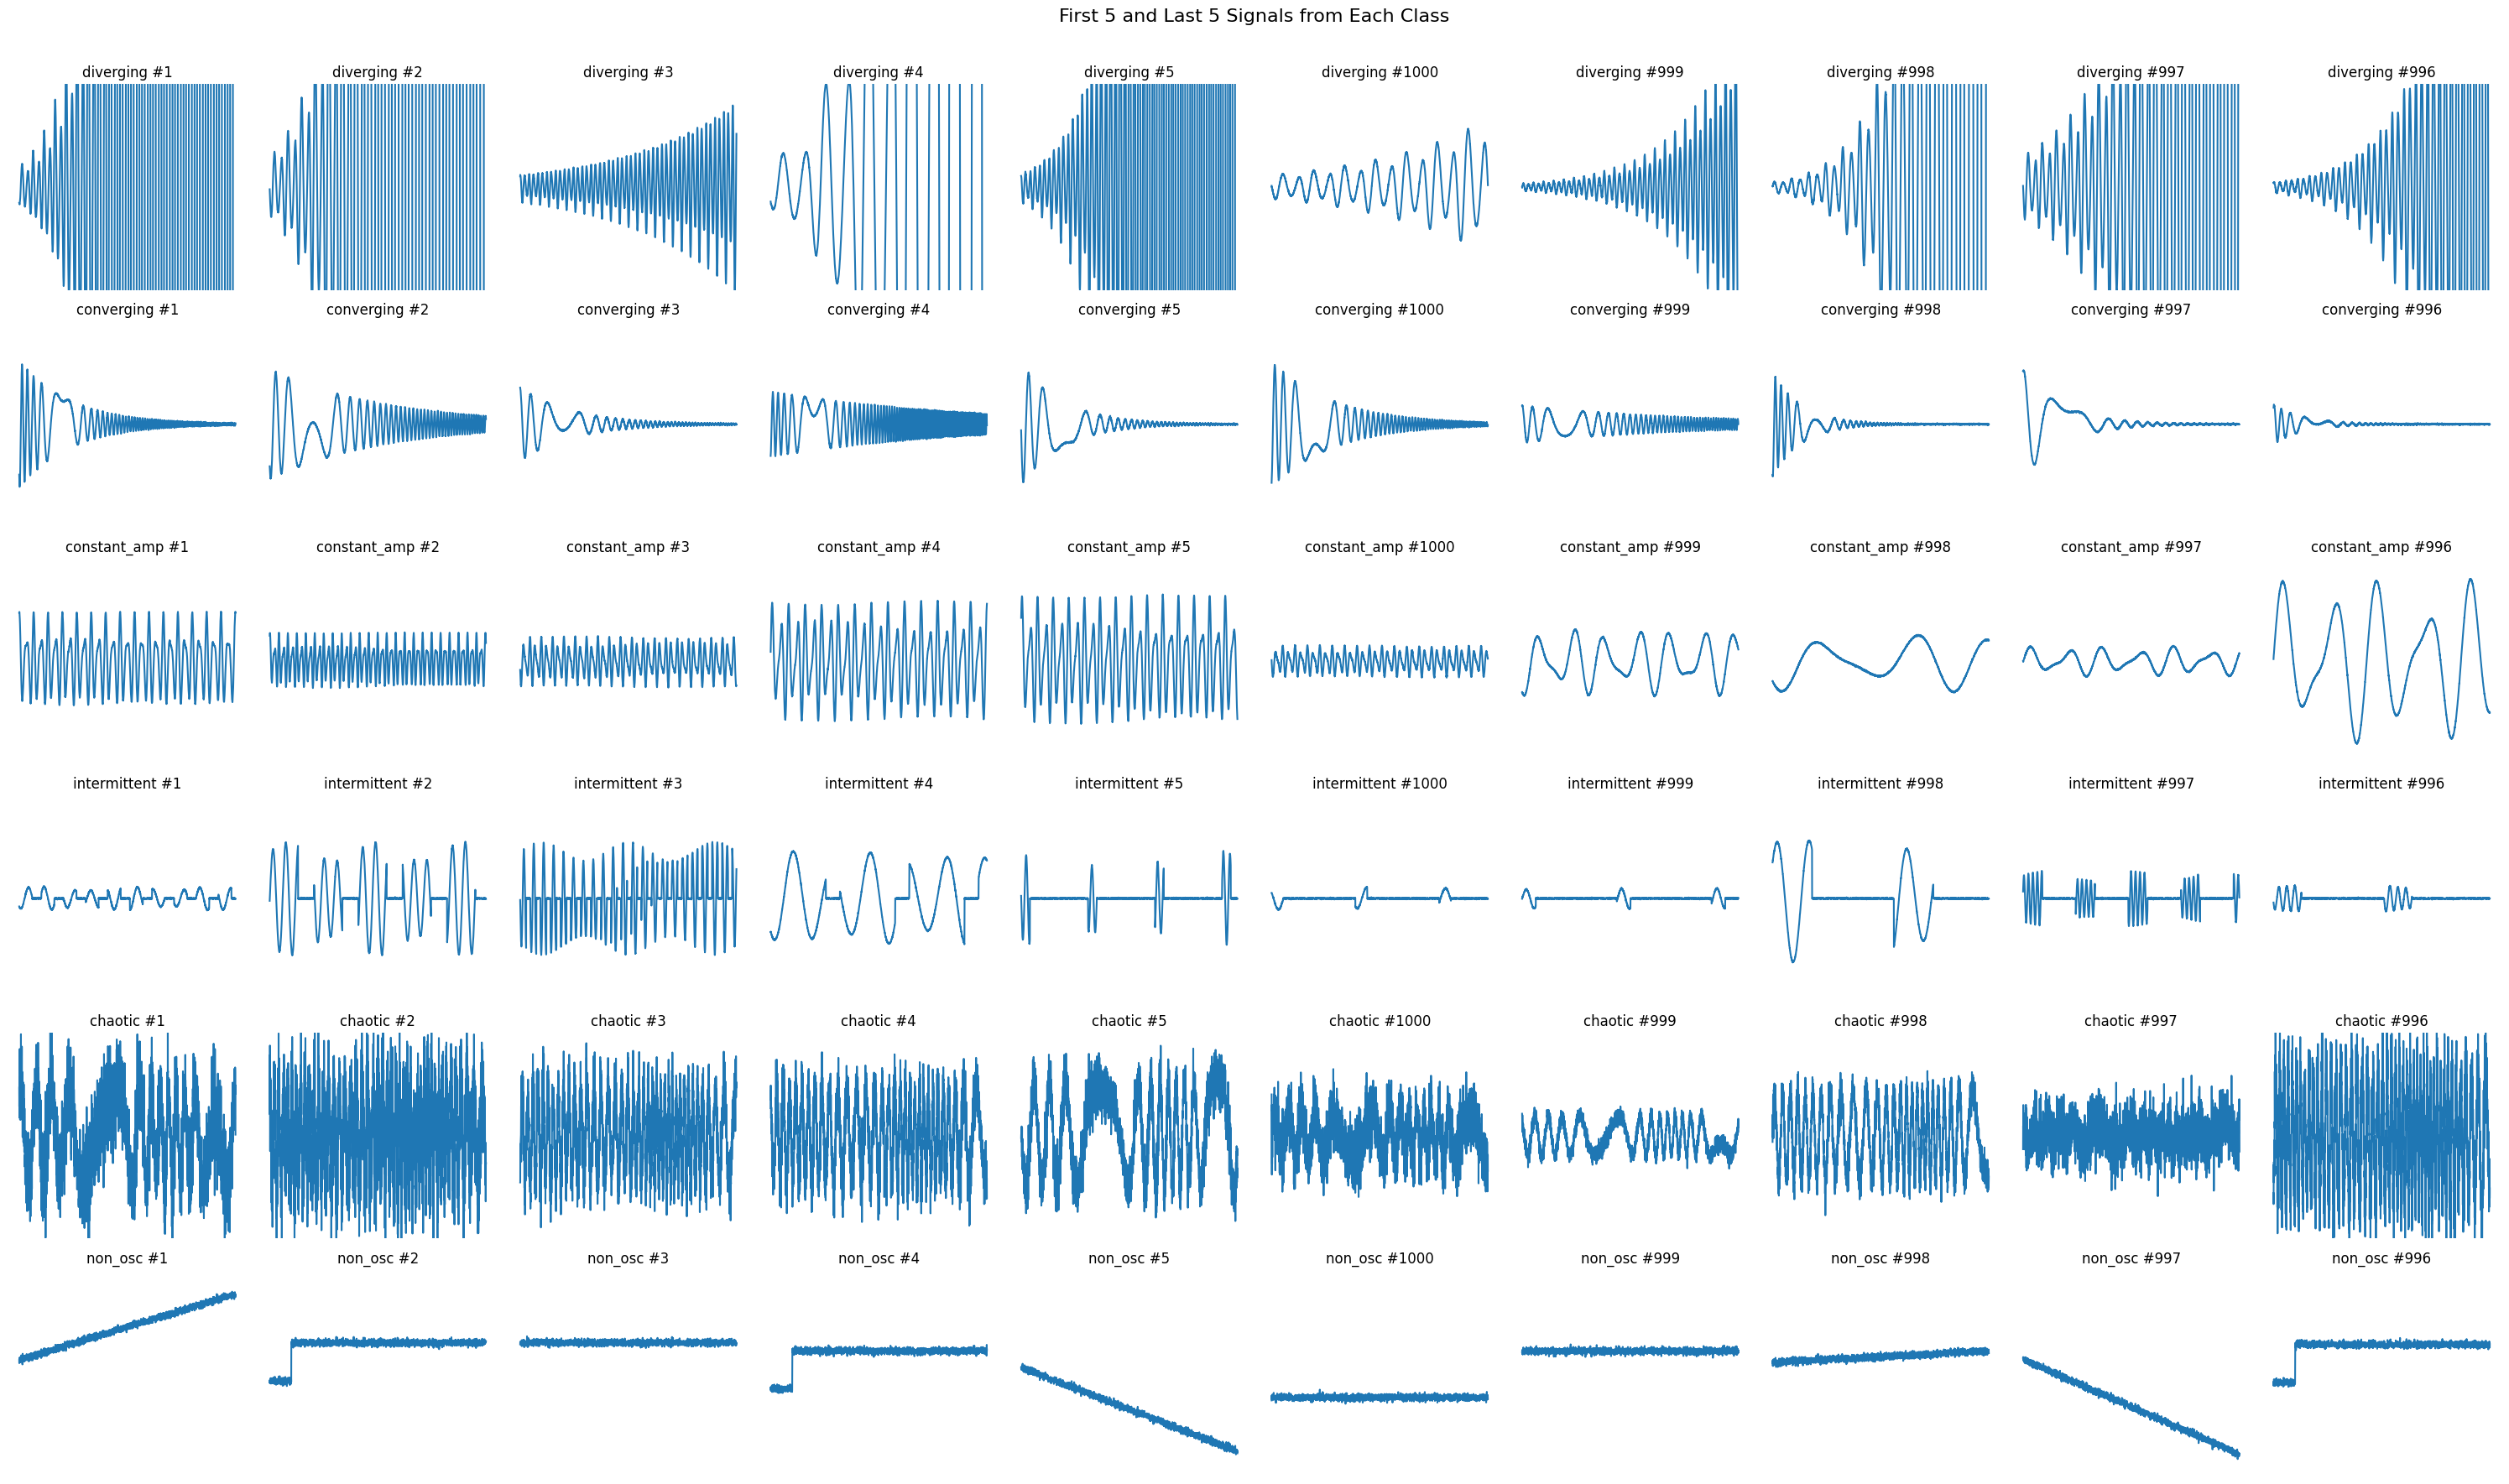

In [14]:
# Plot first 5 and last 5 signals from each class
# Read from the saved CSV to ensure correctness
dataset_df = pd.read_csv("oscillation_dataset_1000_real.csv")
#dataset_df = pd.read_csv("oscillation_signals_1000.csv")
fig, axes = plt.subplots(len(labels), 10, figsize=(30, 3 * len(labels)))
fig.suptitle("First 5 and Last 5 Signals from Each Class", fontsize=16)
for i, label in enumerate(labels):
    class_signals = dataset_df[dataset_df['label'] == label].iloc[:, 2:].values
    for j in range(5):
        axes[i, j].plot(class_signals[j])
        axes[i, j].set_title(f"{label} #{j+1}")
        axes[i, j].set_ylim(-3, 3)
        axes[i, j].axis('off')
    for j in range(5):
        axes[i, j + 5].plot(class_signals[-(j + 1)])
        axes[i, j + 5].set_title(f"{label} #{len(class_signals)-j}")
        axes[i, j + 5].set_ylim(-3, 3)
        axes[i, j + 5].axis('off')  
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



In [ ]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("catboost_oscillation_dataset_1000_real.csv")

# Split features and labels
X = df.drop(columns=["label"]) # features like mean, std, skew, kurtosis, dominant_freq, etc.
y = df["label"] # labels like 'diverging', 'converging', etc.

# Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create CatBoost pools
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)
test_pool = Pool(X_test, y_test)

# Initialize and train model
model = CatBoostClassifier(
    iterations=500, # this tells the model to build 500 trees
    learning_rate=0.001, # dynamic learning rate could be implemented via custom callback if needed
    depth=14, # Tree depth meaning number of splits in each tree max 16
    loss_function='MultiClass', # Multi-class classification
    eval_metric='Accuracy', # Evaluation metric this can be changed based on requirement like 'TotalF1', 'AUC', etc.
    verbose=100, # Print training progress every 100 iterations
    random_seed=42, # For initialization and reproducibility
    l2_leaf_reg=3, # L2 regularization term on weights
    random_strength= 1.0, # Randomness for score calculation to prevent overfitting
    task_type='CPU',
    allow_writing_files=False
)

# Training and validation of the model
model.fit(train_pool, eval_set=val_pool)

# Evaluate on test set
y_pred = model.predict(test_pool)
y_pred = y_pred.flatten()

# print accuracy for validation and test sets
Y_val_pred = model.predict(val_pool).flatten()
val_accuracy = (Y_val_pred == y_val).mean()
test_accuracy = (y_pred == y_test).mean()
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")        

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Visualize results
NUM_CLASSES = len(labels)
IDX2CLASS = {i: label for i, label in enumerate(labels)}
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm, cmap='Reds')
ax.set_title(f'Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks(range(NUM_CLASSES))
ax.set_yticks(range(NUM_CLASSES))
ax.set_xticklabels([IDX2CLASS[i] for i in range(NUM_CLASSES)], rotation=45, ha='right')
ax.set_yticklabels([IDX2CLASS[i] for i in range(NUM_CLASSES)])
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center', color='black')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'catboost_oscillation_dataset_1000_real_fft.csv'

In [ ]:
# import 2 .csv file and combine them 
import pandas as pd
read_csv1 = pd.read_csv("catboost_oscillation_dataset_1000_real.csv")
read_csv2 = pd.read_csv("catboost_oscillation_dataset_1000_new.csv")
# remove the 1st row from read_csv2
read_csv2 = read_csv2.iloc[1:, :]
# concatenate both csv files
df = pd.concat([read_csv1, read_csv2], ignore_index=True)
#save the combined dataframe to a new csv file
df.to_csv("catboost_oscillation_dataset_2000.csv", index=False)
# print the shape of the combined dataframe
print("Combined dataset shape:", df.shape)

